In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks

In [74]:
def process_image(fgmask,x,y,count):
    ### Function enforces binarization of background substraction, and removes noise from the background
    ### Also re-binarization to remove shadows and draw contours
    #init variables and modify shapes
    area_dummy = []
    example = np.zeros_like(np.stack((fgmask,fgmask,fgmask),axis=-1))  
    cx = 0
    cy = 0
    final_img = np.stack((fgmask,fgmask,fgmask),axis=-1)
    kernel = np.ones((5,5),np.uint8)
    kernel_1 = np.ones((5,5),np.uint8)
    
    #Enforce BG substraction and remove nosie
    final_img = cv2.morphologyEx(final_img, cv2.MORPH_OPEN, kernel)
    final_img = cv2.morphologyEx(final_img, cv2.MORPH_CLOSE, kernel_1)
    final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2GRAY)
    
    #Re-bin to remove noise
    ret,final_img = cv2.threshold(final_img, 200, 255, cv2.THRESH_BINARY)
    
    #find controus
    contours,_ = cv2.findContours(final_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #Find the largest contour, draw circle and find x and y coords
    for i in contours:
        area_dummy.append(np.array(cv2.contourArea(i)).astype(int))
                           
    if len(area_dummy)>0:
        index = np.argmax(np.array(area_dummy))  

        M = cv2.moments(contours[index])
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])

        cv2.drawContours(example, contours[index],  -1, (0, 255, 0), 3)
        cv2.circle(example, (cx, cy), 7, (0, 0, 255), -1)
        if count>1:
            cv2.line(example, (x[-1],y[-1]), (cx,cy),(0, 0, 255), 3)
            if count>2:
                cv2.line(example, (x[-2],y[-2]), (x[-1],y[-1]),(0, 0, 255), 3)
                if count>3:
                    cv2.line(example, (x[-3],y[-3]), (x[-2],y[-2]),(0, 0, 255), 3)
    
    #return: contours with black BG, final binarization, and coordinates
    return example,final_img,[cx,cy]



In [76]:
#File path: change this
file_path = "C:/Users/lehtona6/Dropbox (Aalto)/boulder_example_1.mp4"

#Init variable, video reader, and BG substration
x = []
y= []
count = 0

cap = cv2.VideoCapture(file_path)
fps = cap.get(cv2.CAP_PROP_FPS)

fgbg =  cv2.createBackgroundSubtractorKNN()
#fgbg = cv2.createBackgroundSubtractorMOG2()
#fgbg = cv2.createBackgroundSubtractorMOG()

#Open video and read frame by frame
while cap.isOpened():
    ret,frame = cap.read()
    if ret == False:
        break
    if count == 1:
        frame_size = frame.shape
        second_frame = frame
    
    org_frame = frame.copy()
    
    #Blur image for edge detection
    frame = cv2.GaussianBlur(frame, (7, 7),
                       cv2.BORDER_DEFAULT)
    
    #Reduce background
    fgmask = fgbg.apply(frame)
    
    #process image
    contour_image,filtered, coords = process_image(fgmask,x,y,count)
    
    #save coordinates
    x.append(coords[0])
    y.append(coords[1])
    
    #Process layout of displayed image
    filtered = np.stack((filtered,filtered,filtered),axis=-1) 
    fgmask = np.stack((fgmask,fgmask,fgmask),axis=-1)
    final_img = cv2.hconcat([org_frame,filtered,contour_image])
    final_img=cv2.resize(final_img, (720,520), interpolation = cv2.INTER_AREA)
    
    #display
    cv2.imshow('window-name', final_img)
    
    count += 1
    
    #"q" to close the video
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows() # destroy all opened windows


<ipython-input-70-e03b11362d39>:21: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax2.annotate('Start', xy=(start_loc_1,start_loc_2), xytext=(250, 1000),fontsize = 15,color= "red",
<ipython-input-70-e03b11362d39>:24: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax2.annotate('End', xy=(end_loc_1,end_loc_2), xytext=(250, 900),fontsize = 15,color= "red",


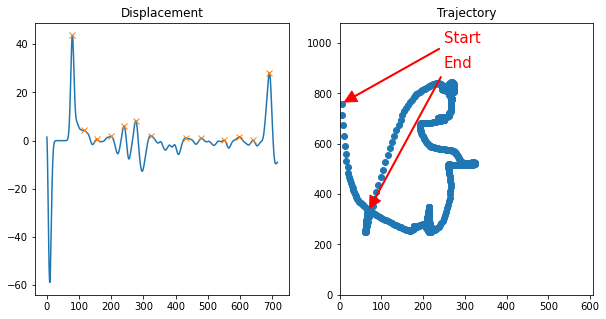

Estimated climbing time: 20.4 s


In [70]:
#Find the starting point and ending point of the event and plot it with trajectories

#Create time vector
frame_time = 1/fps
time_vector = np.arange(0,len(disp)*1/fps,frame_time)

#init figure
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 5))

#Smooth the noise
disp = gaussian_filter(np.diff(np.sqrt(np.array(x)**2+np.array(y)**2)),5)

#Find and plot the velocity peaks that correspond to start and end
ax1.plot(disp)
peaks, _ = find_peaks(disp, height=0)
ax1.set_title("Displacement")
ax1.plot(peaks, disp[peaks], "x")
ax1.set_xlabel("Index of observation")
ax1.set_ylabel("Displacement [pixel]")

#Plot trajecties
ax2.set_title("Trajectory")

start = np.where(disp == np.sort(disp[peaks])[-2:][1])[0][0]
end = np.where(disp == np.sort(disp[peaks])[-2:][0])[0][0]
ax2.scatter(gaussian_filter(np.array(x),5)[start:],gaussian_filter(np.array(np.max(y)-y),5)[start:])
ax2.set_ylim(0,frame_size[0])
ax2.set_xlim(0,frame_size[1])

ax1.set_ylabel("y-coordinate [pixel]")
ax1.set_xlabel("x-coordinate [pixel]")

start_loc_1 = gaussian_filter(np.array(x),5)[start]
start_loc_2 = gaussian_filter(np.array(np.max(y)-y),5)[start]
end_loc_1 = gaussian_filter(np.array(x),5)[end]
end_loc_2 = gaussian_filter(np.array(np.max(y)-y),5)[end]

ax2.annotate('Start', xy=(start_loc_1,start_loc_2), xytext=(250, 1000),fontsize = 15,color= "red",
            arrowprops=dict(facecolor='black', shrink=0.025, width=1,color= "red"))

ax2.annotate('End', xy=(end_loc_1,end_loc_2), xytext=(250, 900),fontsize = 15,color= "red",
            arrowprops=dict(facecolor='black', shrink=0.025, width=1,color= "red"))

#Time between start and end
time = np.abs(time_vector[np.where(disp == np.sort(disp[peaks])[-2:][0])[0][0]]-time_vector[np.where(disp == np.sort(disp[peaks])[-2:][1])[0][0]])

plt.show()
print("Estimated climbing time:", time,"s")

## Ideas and problems

1. Espicially in the beging BG substraction tangles
2. How to find start and end points when:
    - There is lot of noise in the beggining
    - Object does not jump down
    - Object walks into the frame
3. How to deal if the object have the same color clothes as the wall
4. What if the is multiple targets
    - Use the size of the contour, location, and ... to compare euclidean distance between candidates and choose the shortest
5. What other information can we get from the video than displacement
    - Detect the holds?
6. Overlay frame with the trajectory to see draw the climbing path



